In [25]:
using LinearAlgebra, PreallocationTools, ForwardDiff, DiffResults
using MPI
include("XBraid.jl")
using .XBraid

MPI.Init()
comm = MPI.COMM_WORLD

MPI.Comm(Ptr{Nothing} @0x00007fb17a3efc20)

In [26]:
# system parameters (globally scoped)
const nₓ = 64
const Δx = 2π / nₓ
const Δt = 0.1
x = Array(range(0.0, 2π - Δx, nₓ))

# preallocations (performance critical, passed as arguments)
x_new = zeros(nₓ)
y_new = zeros(nₓ)

struct burger_app
    x
    # preallocated caches that support ForwardDiff:
    x_d::DiffCache
    y_d::DiffCache
    solution # stores the total solution vecdtor over space-time
    lyap_vecs # stores the lyapunov vectors
    lyap_exps # stores the lyapunov exponents
    times
end
burger_app(x, x_d, y_d) = burger_app(x, x_d, y_d, [], [], [], [])


burger_app

In [41]:
function interp_periodic(coord, f)
    bound = nₓ
    scaled = coord / Δx
    i = trunc(scaled)
    r = scaled - i
    i = mod1(Int(i + 1), bound)
    (1 - r) * f[i] + r * f[mod1(i + 1, bound)]
end

function semi_lagrangian!(burger::burger_app, y, Δt)
    x_back = get_tmp(burger.x_d, y)
    y_intp = get_tmp(burger.y_d, y)

    x_back .= x .- Δt * y
    y_intp .= interp_periodic.(x_back, Ref(y))
    y .= y_intp
    return y
end

function my_init(burger, t)
    u = similar(x)
    @. u = exp(-1*(π - x)^2)
    # u .= sin.(x) .+ 1e-2*randn(length(x))
    # u .= sin.(x)
    return u
end

function my_basis_init(burger, t, k)
    ψ = similar(burger.x)
    if k % 2 == 0
        @. ψ = cos(k/2*x)
    else
        @. ψ = sin((k+1)/2*x)
    end
    return ψ
end

function my_step!(burger, status, u, ustop, tstart, tstop)
    Δt = tstop - tstart
    u = semi_lagrangian!(burger, u, Δt)
    return
end

function my_step!(burger, status, u, ustop, tstart, tstop, Ψ)
    Δt = tstop - tstart
    rank = length(Ψ)
    Ψ_new = reduce(hcat, Ψ)
    # perturb(r) = semi_lagrangian!(burger, u + Ψ_new * r, Δt)
    perturb(r) = semi_lagrangian!(burger, u + r' * Ψ, Δt)

    result = DiffResults.DiffResult(u, Ψ_new)
    result = ForwardDiff.jacobian!(result, perturb, zeros(rank))
    for i in 1:length(Ψ)
        Ψ[i] .= Ψ_new[:, i]
    end
end

function my_sum!(burger, a, x, b, y)
    @. y = a*x + b*y
end

function my_access(burger, status, u)
    push!(burger.solution, deepcopy(u))
    t = XBraid.status_GetT(status)
    ti = XBraid.status_GetTIndex(status)
    push!(burger.times, t)
    Ψ = XBraid.status_GetBasisVectors(status)
    push!(burger.lyap_vecs, deepcopy(Ψ))
    λ = XBraid.status_GetLocalLyapExponents(status)
    push!(burger.lyap_exps, deepcopy(λ))
end

my_norm(burger, u) = LinearAlgebra.norm2(u)
my_innerprod(burger, u, v) = u' * v

my_innerprod (generic function with 1 method)

In [42]:
burger = burger_app(x, DiffCache(x_new), DiffCache(y_new));

# test user routines:
test_app = XBraid.BraidApp(
    burger, comm, comm, 
    my_step!, my_init,
    my_sum!, my_norm, my_access,
    my_basis_init, my_innerprod);
XBraid.testInitAccess(test_app, 0.)
XBraid.testSpatialNorm(test_app, 0.)
XBraid.testDelta(test_app, 0., 0.1, 3)


Starting braid_TestInitAccess

   braid_TestInitAccess:   Starting Test 1
   braid_TestInitAccess:   u = init(t=0.00e+00)
   braid_TestInitAccess:   access(u) 
   braid_TestInitAccess:   check output: wrote u for initial condition at t=0.00e+00. 

   braid_TestInitAccess:   free(u) 
Finished braid_TestInitAccess
Serialized size of user vector: 560
Check output for objects not properly freed:
IdDict{Any, Any}()



Starting braid_TestSpatialNorm

   braid_TestSpatialNorm:   Starting Test 1
   braid_TestSpatialNorm:   u = init(t=0.00e+00)
   braid_TestSpatialNorm:   spatialnorm(u) 
   braid_TestSpatialNorm:   v = clone(u)
   braid_TestSpatialNorm:   v = u - v 
   braid_TestSpatialNorm:   spatialnorm(v) 
   braid_TestSpatialNorm:   Test 1 Passed
   braid_TestSpatialNorm:   actual output:    spatialnorm(v) = 0.00e+00  
   braid_TestSpatialNorm:   expected output:  spatialnorm(v) = 0.0 

   braid_TestSpatialNorm:   Starting Test 2
   braid_TestSpatialNorm:   w = clone(u)
   braid_TestSpatialNorm:   w = u + w 
   braid_TestSpatialNorm:   spatialnorm(u)
   braid_TestSpatialNorm:   spatialnorm(w)
   braid_TestSpatialNorm:   Test 2 Passed
   braid_TestSpatialNorm:   actual output:    spatialnorm(w) / spatialnorm(u) = 7.15e+00 / 3.57e+00 = 2.00e+00 
   braid_TestSpatialNorm:   expected output:  spatialnorm(w) / spatialnorm(u) = 2.0 

   braid_TestSpatialNorm:   Starting Test 3
   braid_TestSpatialNorm:  

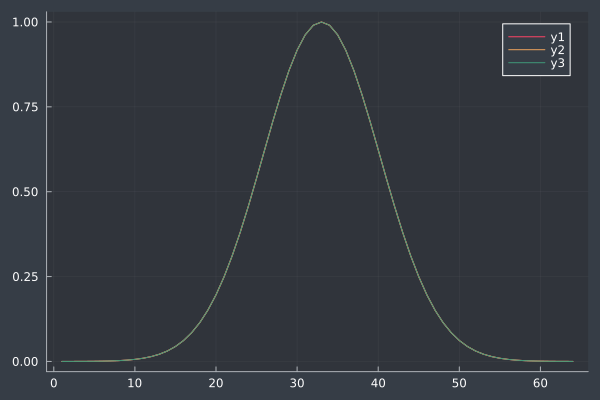

In [43]:
using Plots
theme(:dark)
plot(burger.solution)

In [77]:
burger = burger_app(x, DiffCache(x_new), DiffCache(y_new));
tstart = 0.0
tstop = 8.0
ntime = 256
delta_rank = 16

core = XBraid.Init(
    comm, comm, tstart, tstop, ntime,
    my_step!, my_init, my_sum!, my_norm, my_access; app=burger
);
XBraid.SetDeltaCorrection(core, delta_rank, my_basis_init, my_innerprod)
XBraid.SetLyapunovEstimation(core, false, true, true)
XBraid.SetMaxLevels(core, 3)
XBraid.SetCFactor(core, -1, 4)
XBraid.SetAccessLevel(core, 1)
XBraid.SetNRelax(core, -1, 1)

0

In [78]:
XBraid.Drive(core)


  Braid: Begin simulation, 256 time steps
  Braid: || r_0 || not available, wall time = 1.91e-01
  Braid: || r_1 || = 6.553109e-01, conv factor = 1.00e+00, wall time = 4.81e-01
  Braid: || r_2 || = 1.893478e+00, conv factor = 2.89e+00, wall time = 7.91e-01
  Braid: || r_3 || = 7.367408e-01, conv factor = 3.89e-01, wall time = 1.16e+00
  Braid: || r_4 || = 2.428327e-01, conv factor = 3.30e-01, wall time = 1.38e+00
  Braid: || r_5 || = 2.741279e-01, conv factor = 1.13e+00, wall time = 1.60e+00
  Braid: || r_6 || = 1.534823e-02, conv factor = 5.60e-02, wall time = 1.82e+00
  Braid: || r_7 || = 8.781804e-04, conv factor = 5.72e-02, wall time = 2.03e+00
  Braid: || r_8 || = 1.764121e-04, conv factor = 2.01e-01, wall time = 2.24e+00
  Braid: || r_9 || = 4.276744e-05, conv factor = 2.42e-01, wall time = 2.47e+00
  Braid: || r_10 || = 9.506121e-06, conv factor = 2.22e-01, wall time = 2.70e+00
  Braid: || r_11 || = 1.765920e-06, conv factor = 1.86e-01, wall time = 2.93e+00
  Braid: || r_12 || 

0

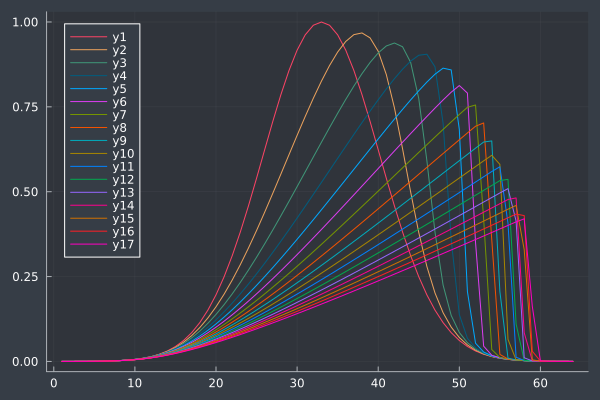

In [79]:
p = sortperm(burger.times)
plot(burger.solution[p][1:16:end])

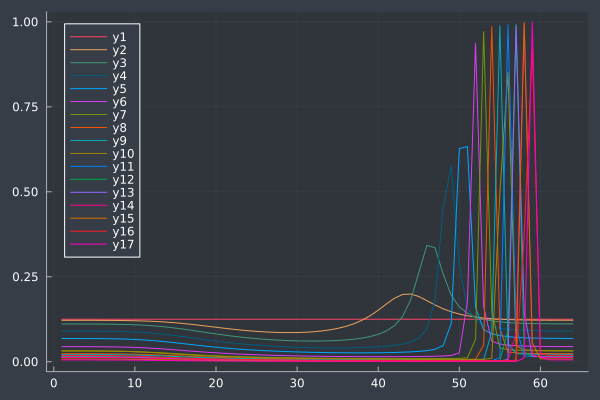

In [80]:
plot([v[1] for v in burger.lyap_vecs[p][1:16:end]])
# plot(burger.lyap_vecs[p][end][1])

In [81]:
sum(burger.lyap_exps[p]) ./ tstop

16-element Vector{Float64}:
  0.3960664204928319
 -0.012749095793724243
 -0.15670457463405488
 -0.17898127816409387
 -0.20962615880184074
 -0.32688861269750596
 -0.25678468257324355
 -0.44427613547031025
 -0.37859040545272826
 -0.559196793524818
 -0.5564878077827246
 -0.6640045591683187
 -0.925058671159648
 -0.8237824457115515
 -1.125106119994004
 -1.2121245566484922

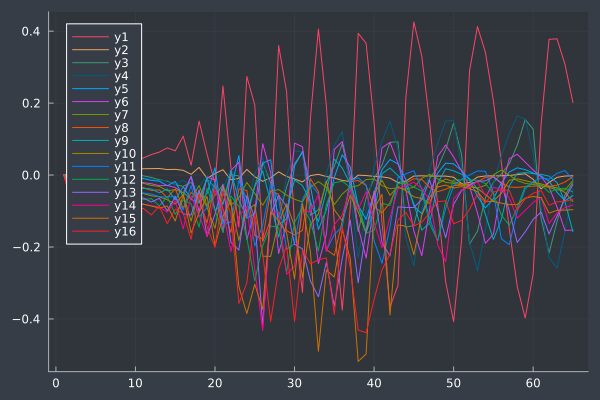

In [82]:
plot(reduce(vcat, burger.lyap_exps[p][1:4:end]'))

In [74]:
reduce(vcat, burger.lyap_exps[p][1:4:end]')

33×16 Matrix{Float64}:
  0.0          0.0         …   0.0         0.0         0.0
  0.00154385   0.00238891     -0.063427   -0.0634281  -0.0826852
  0.00461405   0.00394878     -0.0606861  -0.0606872  -0.0788653
  0.00780138   0.00553327     -0.0600098  -0.0600105  -0.0776114
  0.0112974    0.0071888      -0.0607779  -0.0607772  -0.078049
  0.0152894    0.00894312  …  -0.0626354  -0.0626327  -0.0796861
  0.0199664    0.0107984      -0.0653403  -0.0653394  -0.0822034
  0.0255058    0.0127163      -0.0687215  -0.0686891  -0.0853667
  0.0320337    0.0145978      -0.0724491  -0.0726726  -0.0887343
  0.0395769    0.0162821      -0.0768775  -0.076609   -0.0940321
  ⋮                        ⋱                           ⋮
  0.194687    -0.00437617     -0.287222   -0.164045   -0.156046
 -0.18376     -0.0195559   …  -0.386023   -0.287965   -0.164372
 -0.121194    -0.0091169      -0.156454   -0.371113   -0.168975
  0.358729     0.0101536      -0.183132   -0.247184   -0.0646015
  0.231961    -0.003